In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
def conv_block(inputs, num_filter):
    x = layers.Conv2D(num_filter, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filter, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [3]:
def encoder_block(inputs,num_filter):
    x = conv_block(inputs, num_filter)
    p = layers.MaxPool2D((2, 2))(x)
    return x,p

In [4]:
def decoder_block(inputs, skip, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    x = layers.concatenate([x, skip])
    x = conv_block(x, num_filters)
    return x

In [5]:
def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    """ Bridge """
    b1 = conv_block(p4, 1024)

    """ Decoder """

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")

    return model

In [8]:
input_shape = (256, 256, 1)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                             

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
precision = tf.keras.metrics.Precision(
    thresholds=0.5)
recall = tf.keras.metrics.Recall(
    thresholds=0.5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[precision,recall])

data

In [16]:
# datasets for tf
from data_preprocessing import get_dataset_large

batch_size = 4
dataset = get_dataset_large("data/LITS_TFRecords_2D/train/"
)
dataset = dataset.shuffle(5000,reshuffle_each_iteration=True).batch(batch_size)
valid_dataset = get_dataset_large("data/LITS_TFRecords_2D/valid/"
)
valid_dataset = valid_dataset.batch(
    batch_size
)  # .shuffle(1000,  reshuffle_each_iteration=True)

for sample in dataset.take(1):
    print(sample[0].shape)
    print(sample[1].shape)
for sample in valid_dataset.take(1):
    print(sample[0].shape)
    print(sample[1].shape)


['data/LITS_TFRecords_2D/train\\images0.tfrecords', 'data/LITS_TFRecords_2D/train\\images1.tfrecords', 'data/LITS_TFRecords_2D/train\\images10.tfrecords', 'data/LITS_TFRecords_2D/train\\images11.tfrecords', 'data/LITS_TFRecords_2D/train\\images12.tfrecords', 'data/LITS_TFRecords_2D/train\\images13.tfrecords', 'data/LITS_TFRecords_2D/train\\images14.tfrecords', 'data/LITS_TFRecords_2D/train\\images2.tfrecords', 'data/LITS_TFRecords_2D/train\\images3.tfrecords', 'data/LITS_TFRecords_2D/train\\images4.tfrecords', 'data/LITS_TFRecords_2D/train\\images5.tfrecords', 'data/LITS_TFRecords_2D/train\\images6.tfrecords', 'data/LITS_TFRecords_2D/train\\images7.tfrecords', 'data/LITS_TFRecords_2D/train\\images8.tfrecords', 'data/LITS_TFRecords_2D/train\\images9.tfrecords']
['data/LITS_TFRecords_2D/valid\\images0.tfrecords', 'data/LITS_TFRecords_2D/valid\\images1.tfrecords', 'data/LITS_TFRecords_2D/valid\\images2.tfrecords', 'data/LITS_TFRecords_2D/valid\\images3.tfrecords', 'data/LITS_TFRecords_2D/

fit?

In [17]:
# Results
# reading checkpoint if needen
#
import datetime
#################################
from clearml import Task
task = Task.init(project_name='master_2D', task_name='model_yt')
# add tensorboard
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TerminateOnNaN,
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# training
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    #ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0000001, verbose=1),
    ModelCheckpoint(
        "models\\new_yt\\{epoch:02d}-{val_loss:.4f}.hdf5",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
    ),
    TerminateOnNaN(),
    tensorboard_callback
]
epochs=10

history = model.fit(
    dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    initial_epoch=0,
)

Epoch 1/10
   7500/Unknown - 1098s 146ms/step - loss: 0.0101 - precision: 0.9277 - recall: 0.9064
Epoch 1: val_loss improved from inf to 0.02521, saving model to models\new_yt\01-0.0252.hdf5
7500/7500 [==============================] - 1205s 160ms/step - loss: 0.0101 - precision: 0.9277 - recall: 0.9064 - val_loss: 0.0252 - val_precision: 0.9295 - val_recall: 0.8212
Epoch 2/10
7500/7500 [==============================] - ETA: 0s - loss: 0.0049 - precision: 0.9603 - recall: 0.9543
Epoch 2: val_loss improved from 0.02521 to 0.02445, saving model to models\new_yt\02-0.0244.hdf5
7500/7500 [==============================] - 1208s 160ms/step - loss: 0.0049 - precision: 0.9603 - recall: 0.9543 - val_loss: 0.0244 - val_precision: 0.9291 - val_recall: 0.8511
Epoch 3/10
7500/7500 [==============================] - ETA: 0s - loss: 0.0036 - precision: 0.9693 - recall: 0.9658
Epoch 3: val_loss did not improve from 0.02445
7500/7500 [==============================] - 1200s 159ms/step - loss: 0.0036 

In [ ]:
# Results
# reading checkpoint if needen
#
import datetime
#################################
from clearml import Task
task = Task.init(project_name='master_2D', task_name='model_yt')
# add tensorboard
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TerminateOnNaN,
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# training
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    #ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0000001, verbose=1),
    ModelCheckpoint(
        "models\\new_yt\\{epoch:02d}-{val_loss:.4f}.hdf5",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
    ),
    TerminateOnNaN(),
    tensorboard_callback
]
epochs=10

history = model.fit(
    dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    initial_epoch=0,
)

Epoch 1/10
   7500/Unknown - 1098s 146ms/step - loss: 0.0101 - precision: 0.9277 - recall: 0.9064
Epoch 1: val_loss improved from inf to 0.02521, saving model to models\new_yt\01-0.0252.hdf5
7500/7500 [==============================] - 1205s 160ms/step - loss: 0.0101 - precision: 0.9277 - recall: 0.9064 - val_loss: 0.0252 - val_precision: 0.9295 - val_recall: 0.8212
Epoch 2/10
7500/7500 [==============================] - ETA: 0s - loss: 0.0049 - precision: 0.9603 - recall: 0.9543
Epoch 2: val_loss improved from 0.02521 to 0.02445, saving model to models\new_yt\02-0.0244.hdf5
7500/7500 [==============================] - 1208s 160ms/step - loss: 0.0049 - precision: 0.9603 - recall: 0.9543 - val_loss: 0.0244 - val_precision: 0.9291 - val_recall: 0.8511
Epoch 3/10
7500/7500 [==============================] - ETA: 0s - loss: 0.0036 - precision: 0.9693 - recall: 0.9658
Epoch 3: val_loss did not improve from 0.02445
7500/7500 [==============================] - 1200s 159ms/step - loss: 0.0036 

In [18]:
from matplotlib import pyplot as plt

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
36.0
278.0
556.0
994.0
1726.0
1/1 [==============================] - 0s 18ms/step


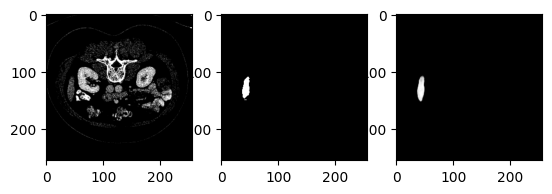

2372.0
1/1 [==============================] - 0s 19ms/step


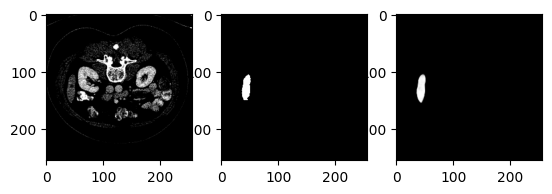

3040.0
1/1 [==============================] - 0s 19ms/step


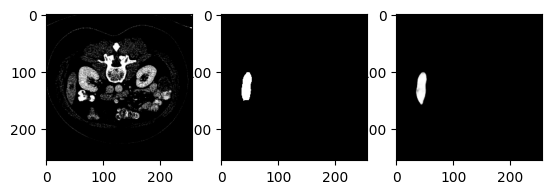

3839.0
1/1 [==============================] - 0s 19ms/step


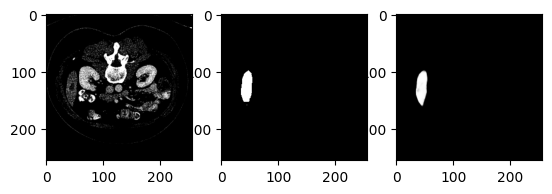

4618.0
1/1 [==============================] - 0s 20ms/step


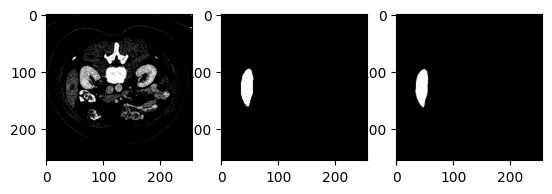

5353.0
1/1 [==============================] - 0s 18ms/step


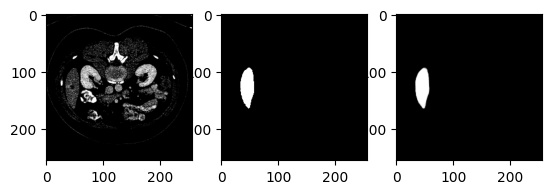

6147.0
1/1 [==============================] - 0s 19ms/step


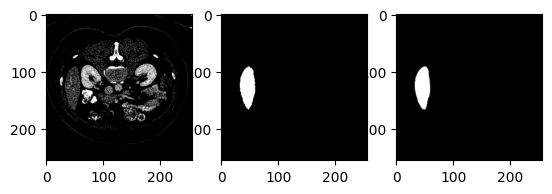

6838.0
1/1 [==============================] - 0s 18ms/step


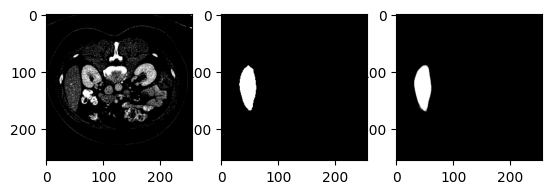

7672.0
1/1 [==============================] - 0s 18ms/step


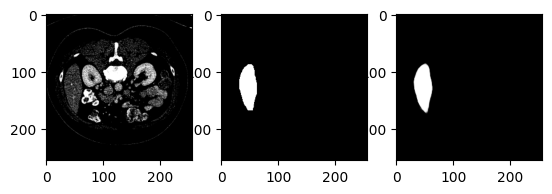

8596.0
1/1 [==============================] - 0s 20ms/step


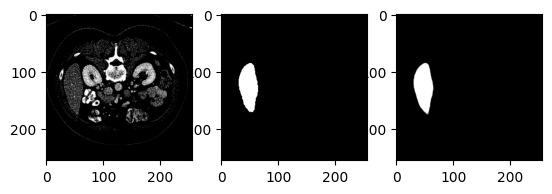

9556.0
1/1 [==============================] - 0s 21ms/step


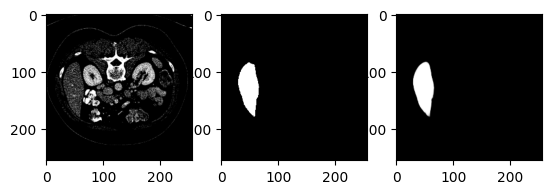

10511.0
1/1 [==============================] - 0s 22ms/step


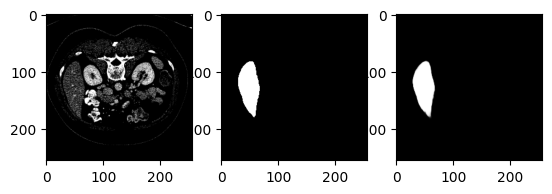

11681.0
1/1 [==============================] - 0s 18ms/step


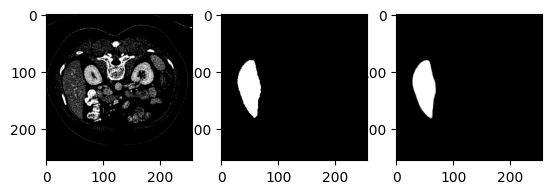

12684.0
1/1 [==============================] - 0s 20ms/step


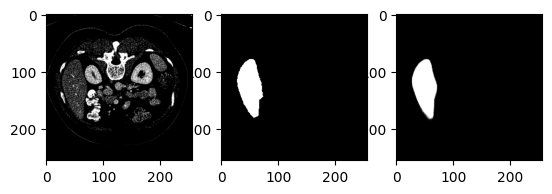

13751.0
1/1 [==============================] - 0s 19ms/step


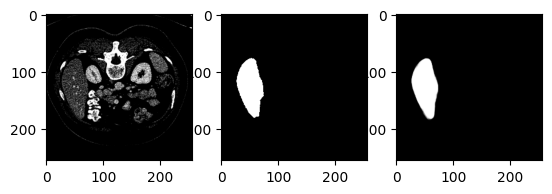

14879.0
1/1 [==============================] - 0s 21ms/step


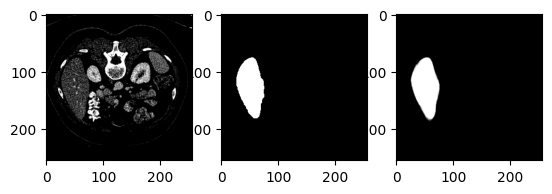

16026.0
1/1 [==============================] - 0s 19ms/step


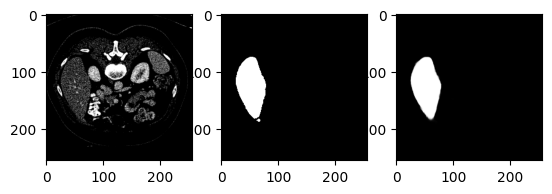

17125.0
1/1 [==============================] - 0s 20ms/step


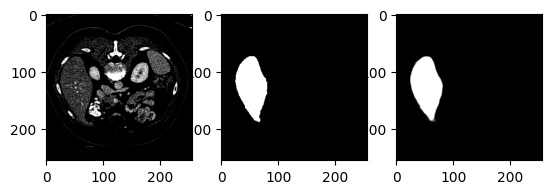

18317.0
1/1 [==============================] - 0s 18ms/step


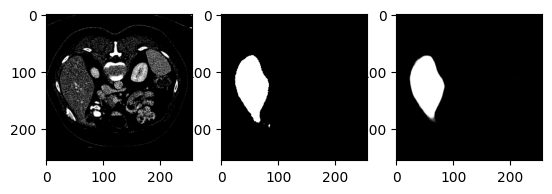

19386.0
1/1 [==============================] - 0s 19ms/step


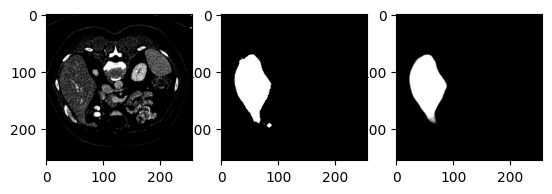

20818.0
1/1 [==============================] - 0s 21ms/step


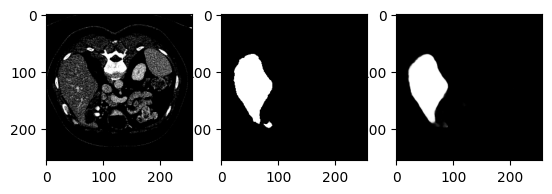

22031.0
1/1 [==============================] - 0s 18ms/step


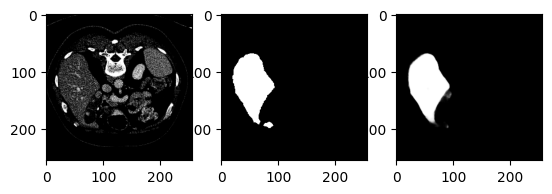

22716.0
1/1 [==============================] - 0s 20ms/step


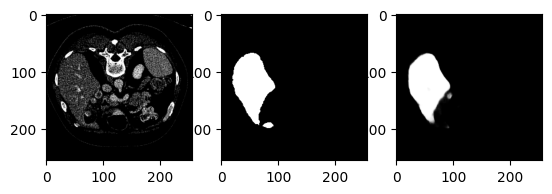

23499.0
1/1 [==============================] - 0s 22ms/step


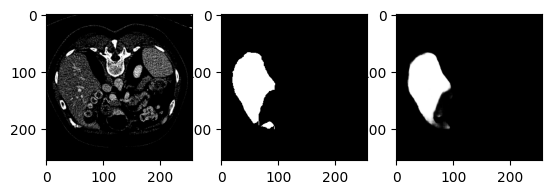

24283.0
1/1 [==============================] - 0s 27ms/step


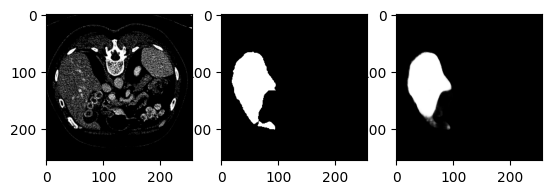

24370.0
1/1 [==============================] - 0s 21ms/step


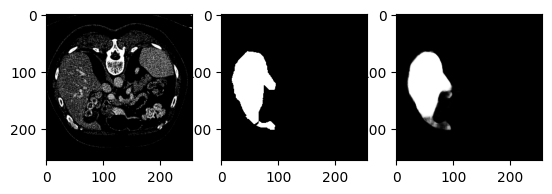

24982.0
1/1 [==============================] - 0s 20ms/step


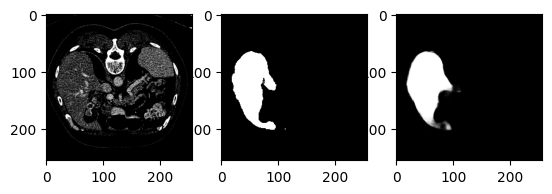

25705.0
1/1 [==============================] - 0s 21ms/step


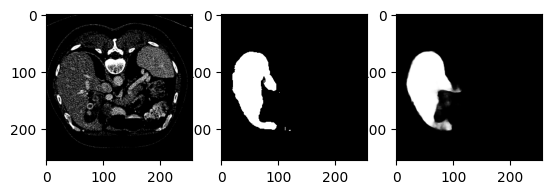

27539.0
1/1 [==============================] - 0s 21ms/step


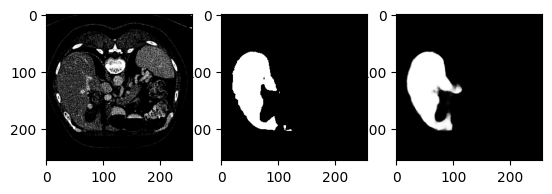

29127.0
1/1 [==============================] - 0s 31ms/step


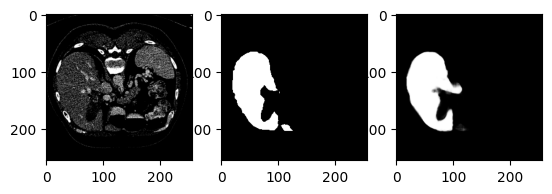

31151.0
1/1 [==============================] - 0s 19ms/step


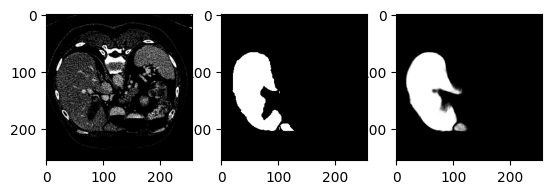

33773.0
1/1 [==============================] - 0s 18ms/step


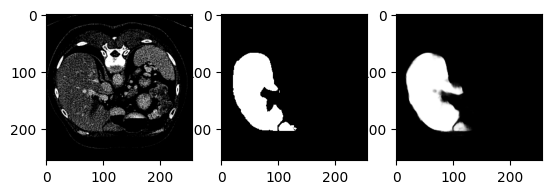

35469.0
1/1 [==============================] - 0s 19ms/step


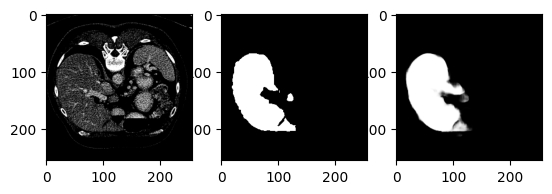

37332.0
1/1 [==============================] - 0s 20ms/step


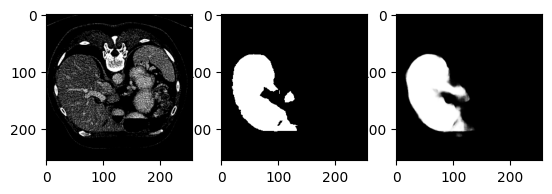

39306.0
1/1 [==============================] - 0s 19ms/step


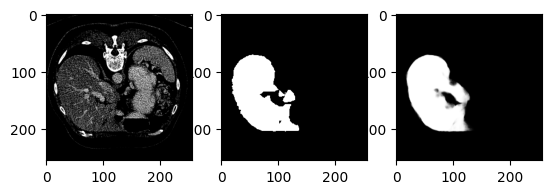

40112.0
1/1 [==============================] - 0s 27ms/step


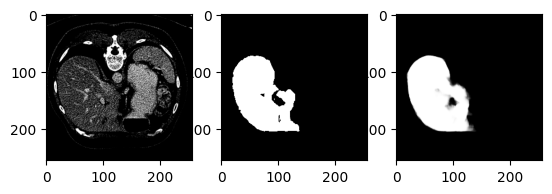

39984.0
1/1 [==============================] - 0s 25ms/step


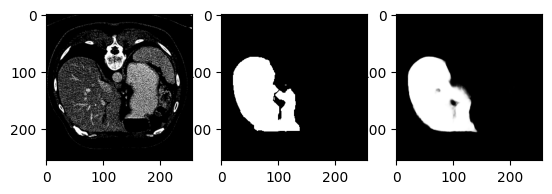

39757.0
1/1 [==============================] - 0s 20ms/step


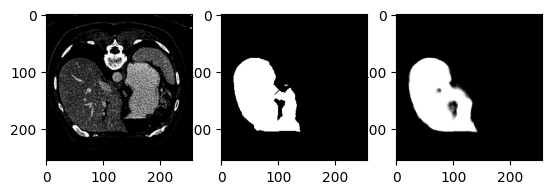

39105.0
1/1 [==============================] - 0s 20ms/step


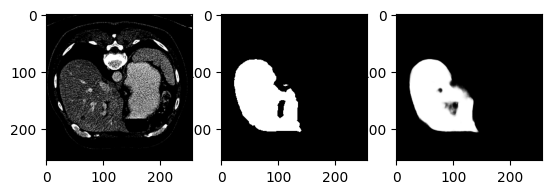

38330.0
1/1 [==============================] - 0s 19ms/step


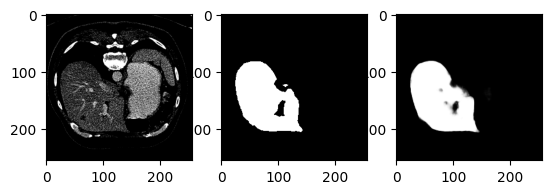

37666.0
1/1 [==============================] - 0s 32ms/step


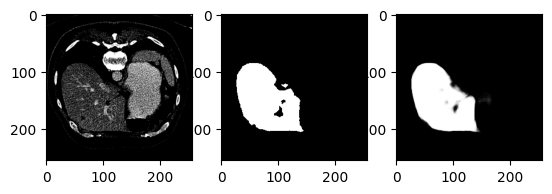

36575.0
1/1 [==============================] - 0s 18ms/step


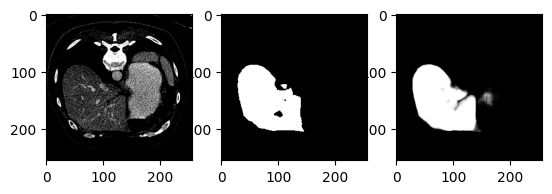

35518.0
1/1 [==============================] - 0s 20ms/step


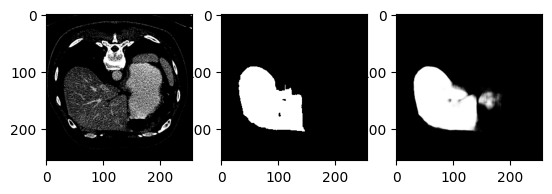

34092.0
1/1 [==============================] - 0s 21ms/step


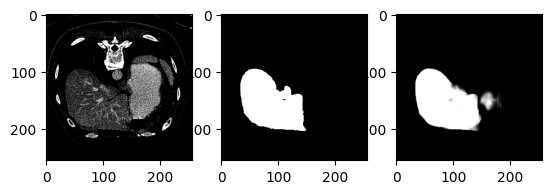

32399.0
1/1 [==============================] - 0s 17ms/step


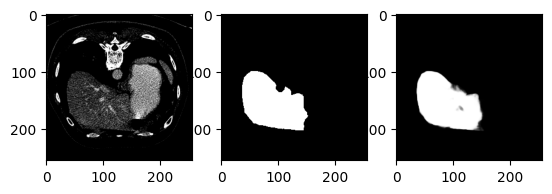

30084.0
1/1 [==============================] - 0s 19ms/step


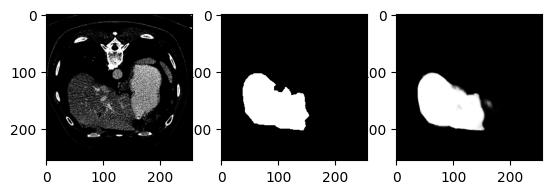

26830.0
1/1 [==============================] - 0s 24ms/step


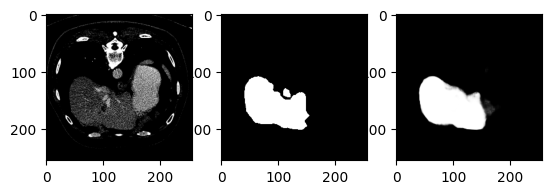

23937.0
1/1 [==============================] - 0s 20ms/step


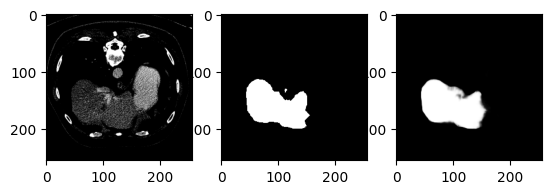

19843.0
1/1 [==============================] - 0s 27ms/step


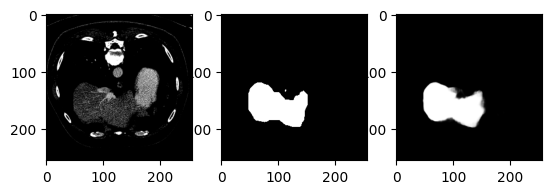

12371.0
1/1 [==============================] - 0s 19ms/step


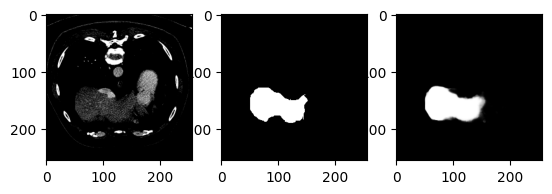

7198.0
1/1 [==============================] - 0s 25ms/step


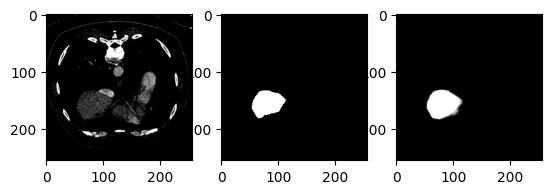

4825.0
1/1 [==============================] - 0s 21ms/step


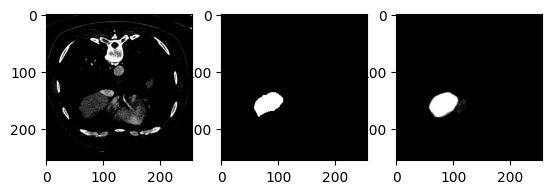

2589.0
1/1 [==============================] - 0s 19ms/step


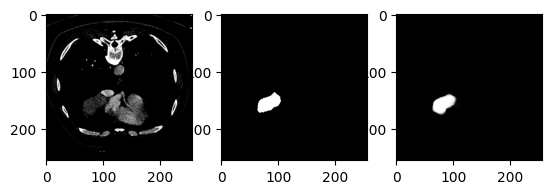

353.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
60.0
578.0
1628.0
1/1 [==============================] - 0s 19ms/step


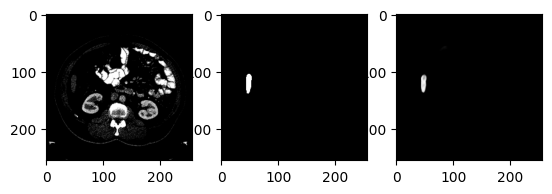

2784.0
1/1 [==============================] - 0s 21ms/step


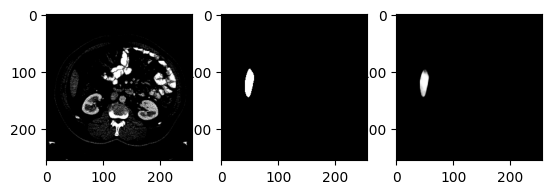

4068.0
1/1 [==============================] - 0s 21ms/step


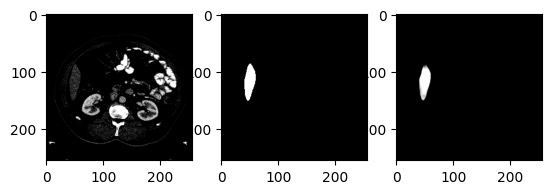

5270.0
1/1 [==============================] - 0s 19ms/step


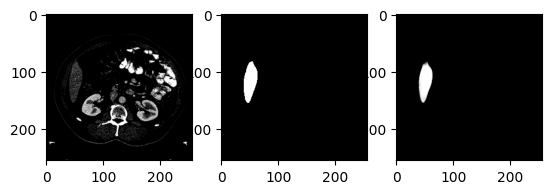

6542.0
1/1 [==============================] - 0s 21ms/step


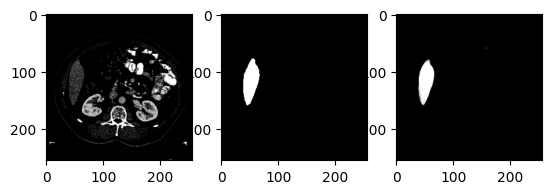

7690.0
1/1 [==============================] - 0s 19ms/step


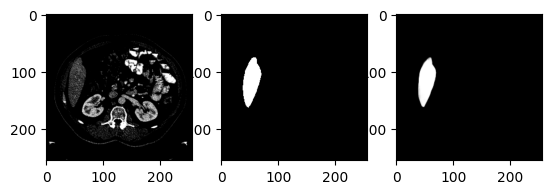

8922.0
1/1 [==============================] - 0s 19ms/step


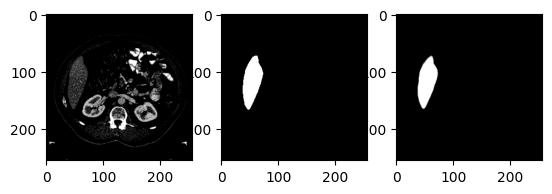

10062.0
1/1 [==============================] - 0s 22ms/step


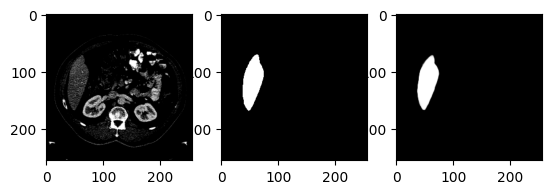

11301.0
1/1 [==============================] - 0s 18ms/step


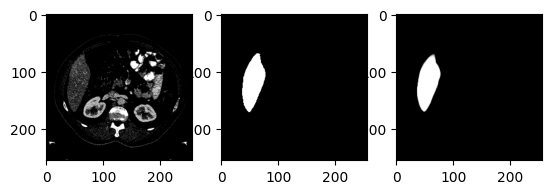

12485.0
1/1 [==============================] - 0s 18ms/step


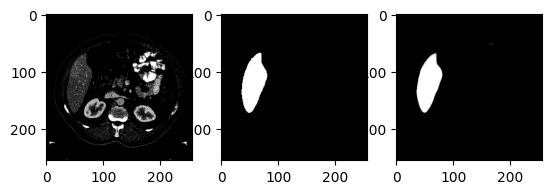

13739.0
1/1 [==============================] - 0s 19ms/step


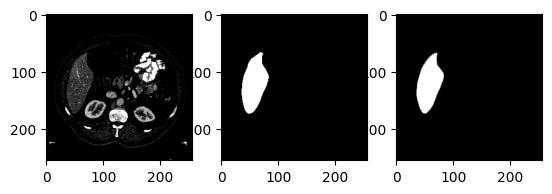

15173.0
1/1 [==============================] - 0s 20ms/step


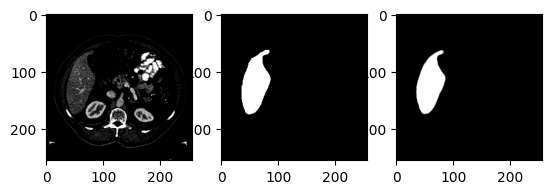

16747.0
1/1 [==============================] - 0s 22ms/step


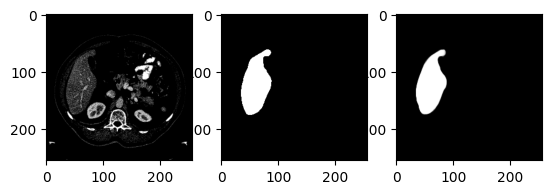

18160.0
1/1 [==============================] - 0s 20ms/step


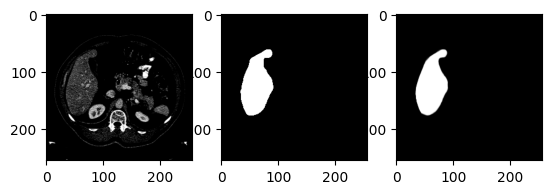

19462.0
1/1 [==============================] - 0s 20ms/step


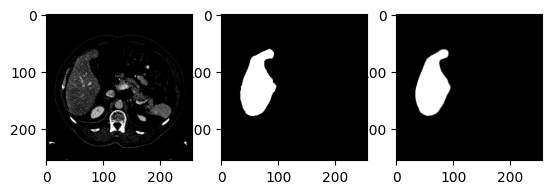

21073.0
1/1 [==============================] - 0s 20ms/step


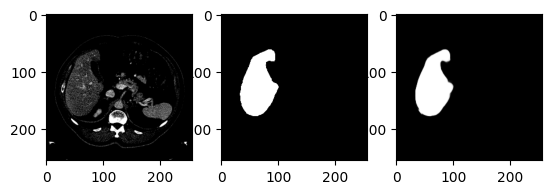

23033.0
1/1 [==============================] - 0s 20ms/step


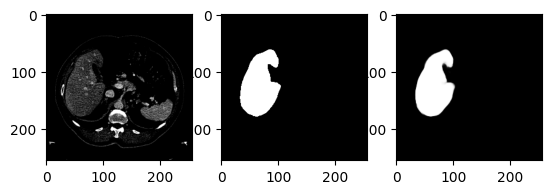

25029.0
1/1 [==============================] - 0s 21ms/step


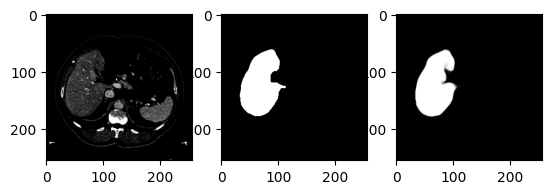

26877.0
1/1 [==============================] - 0s 20ms/step


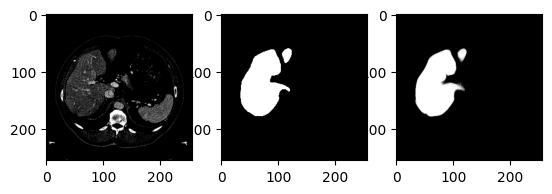

28074.0
1/1 [==============================] - 0s 19ms/step


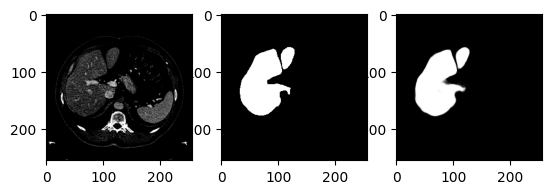

28625.0
1/1 [==============================] - 0s 19ms/step


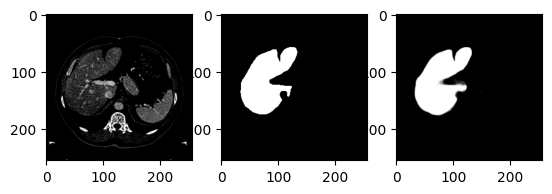

29070.0
1/1 [==============================] - 0s 18ms/step


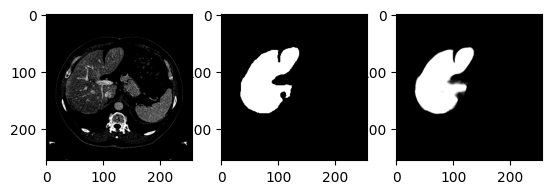

29167.0
1/1 [==============================] - 0s 22ms/step


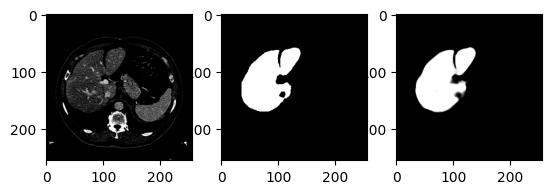

28396.0
1/1 [==============================] - 0s 20ms/step


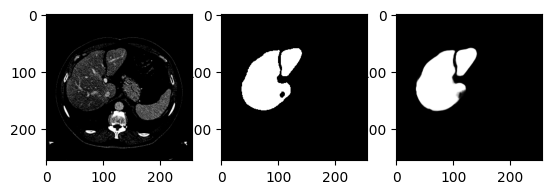

27879.0
1/1 [==============================] - 0s 20ms/step


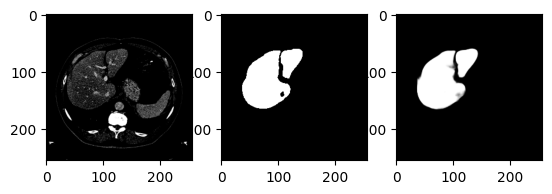

27640.0
1/1 [==============================] - 0s 19ms/step


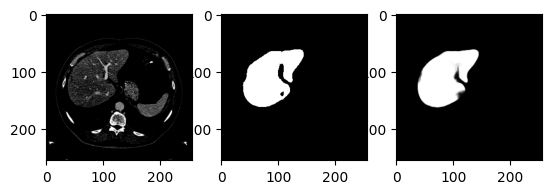

27352.0
1/1 [==============================] - 0s 19ms/step


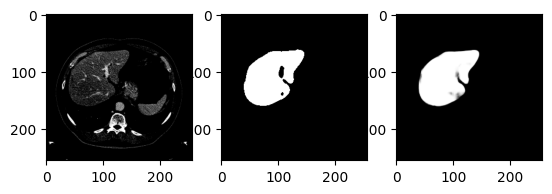

26854.0
1/1 [==============================] - 0s 25ms/step


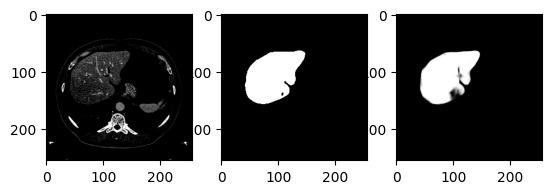

25988.0
1/1 [==============================] - 0s 20ms/step


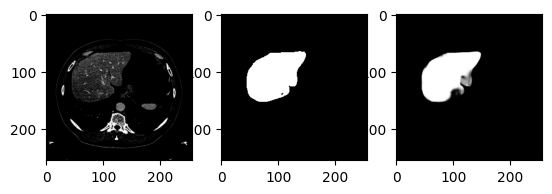

25003.0
1/1 [==============================] - 0s 23ms/step


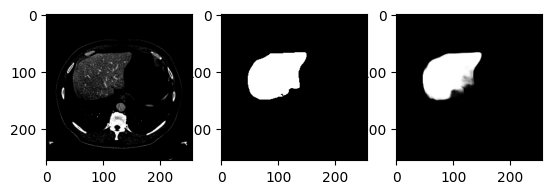

23718.0
1/1 [==============================] - 0s 19ms/step


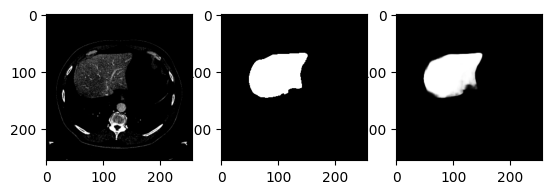

22114.0
1/1 [==============================] - 0s 18ms/step


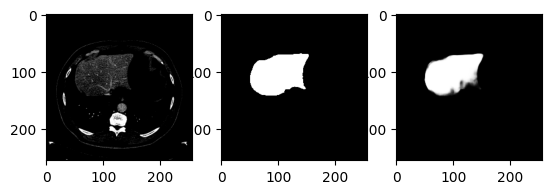

20530.0
1/1 [==============================] - 0s 19ms/step


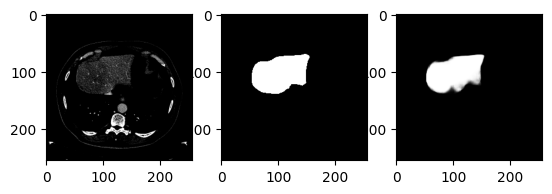

17373.0
1/1 [==============================] - 0s 20ms/step


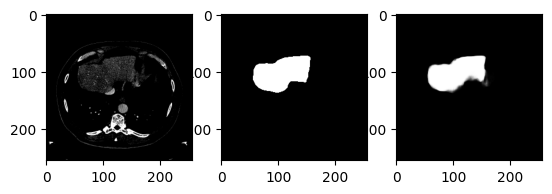

12531.0
1/1 [==============================] - 0s 22ms/step


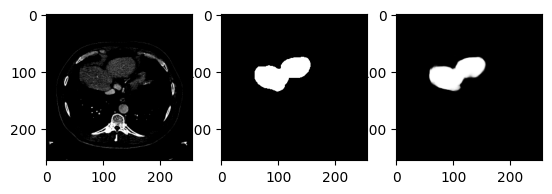

6274.0
1/1 [==============================] - 0s 21ms/step


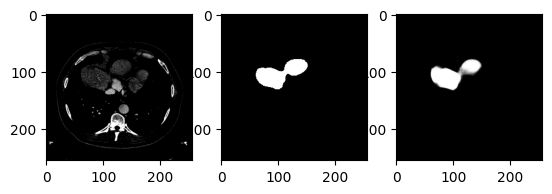

1903.0
1/1 [==============================] - 0s 20ms/step


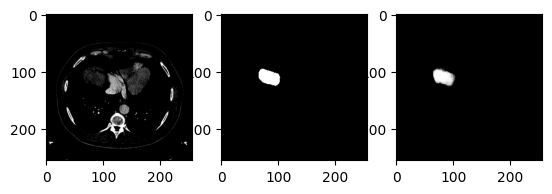

231.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
107.0
521.0
996.0
1433.0
1/1 [==============================] - 0s 17ms/step


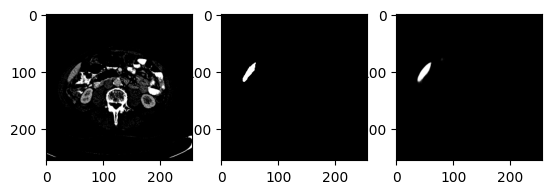

1941.0
1/1 [==============================] - 0s 20ms/step


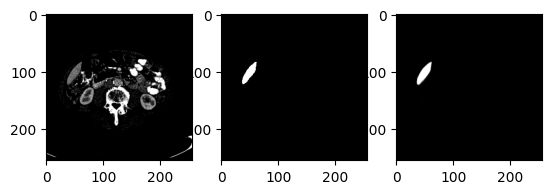

2492.0
1/1 [==============================] - 0s 21ms/step


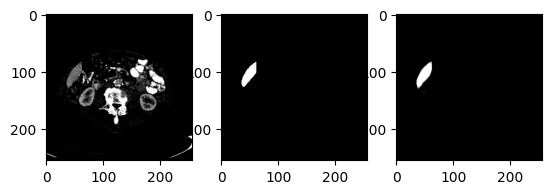

3139.0
1/1 [==============================] - 0s 19ms/step


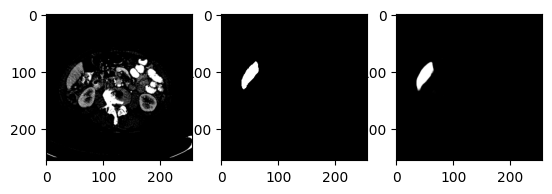

3712.0
1/1 [==============================] - 0s 21ms/step


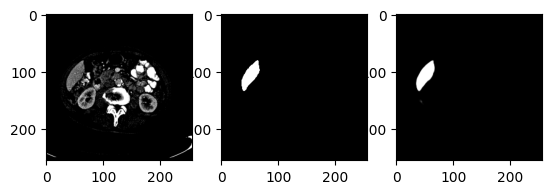

4369.0
1/1 [==============================] - 0s 20ms/step


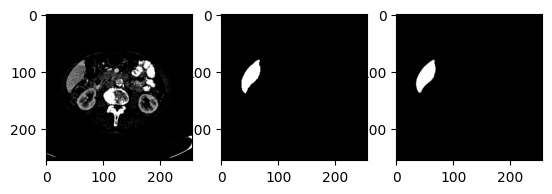

5051.0
1/1 [==============================] - 0s 21ms/step


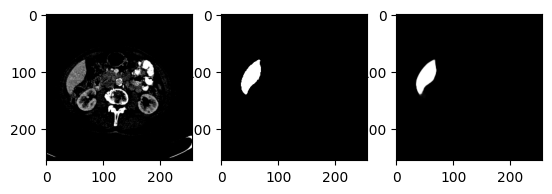

5996.0
1/1 [==============================] - 0s 19ms/step


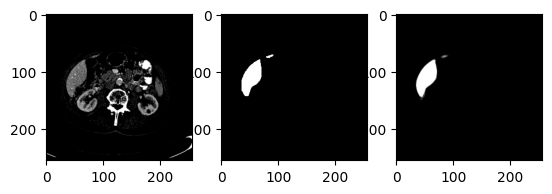

7255.0
1/1 [==============================] - 0s 20ms/step


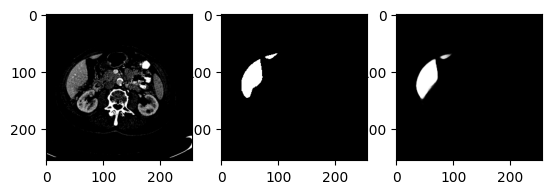

8901.0
1/1 [==============================] - 0s 21ms/step


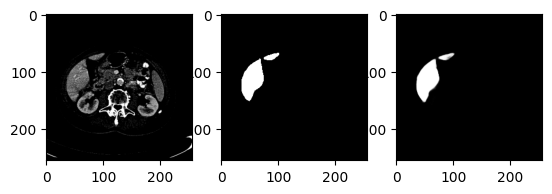

10940.0
1/1 [==============================] - 0s 19ms/step


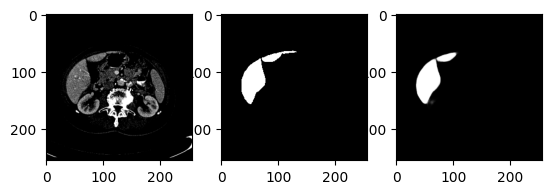

12882.0
1/1 [==============================] - 0s 21ms/step


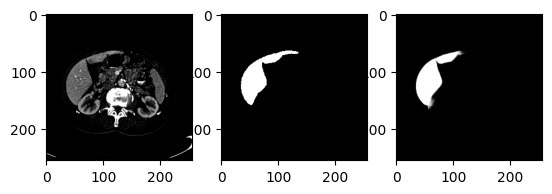

14741.0
1/1 [==============================] - 0s 19ms/step


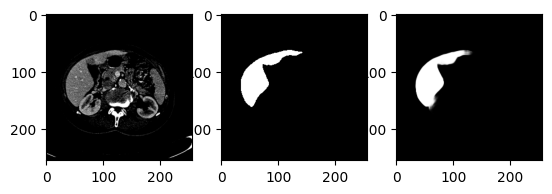

16835.0
1/1 [==============================] - 0s 21ms/step


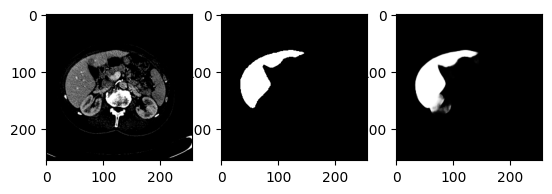

18975.0
1/1 [==============================] - 0s 19ms/step


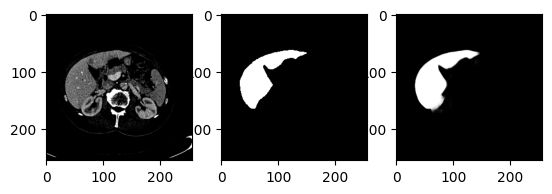

21087.0
1/1 [==============================] - 0s 19ms/step


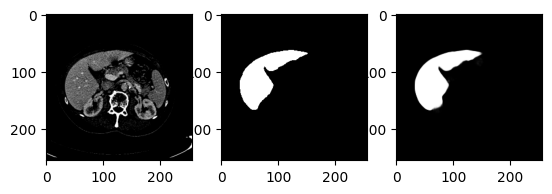

22923.0
1/1 [==============================] - 0s 19ms/step


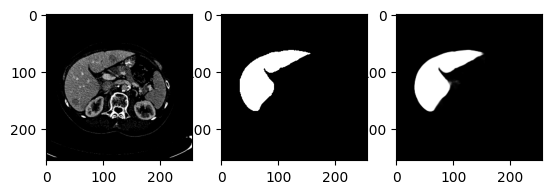

24331.0
1/1 [==============================] - 0s 19ms/step


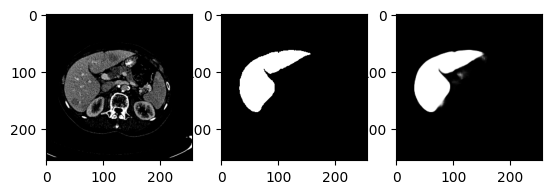

25553.0
1/1 [==============================] - 0s 39ms/step


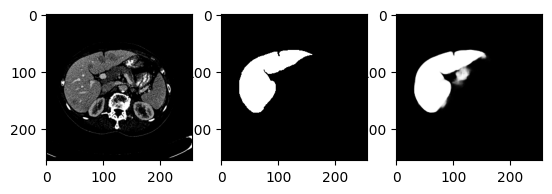

26519.0
1/1 [==============================] - 0s 20ms/step


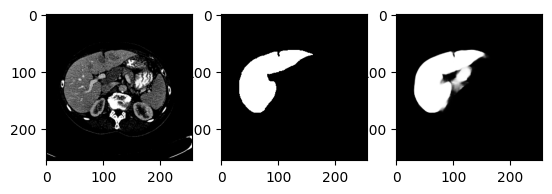

27595.0
1/1 [==============================] - 0s 30ms/step


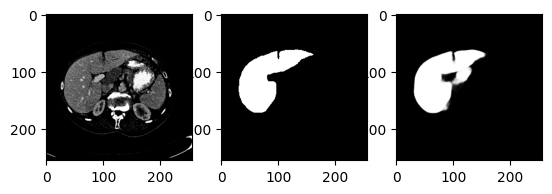

29095.0
1/1 [==============================] - 0s 20ms/step


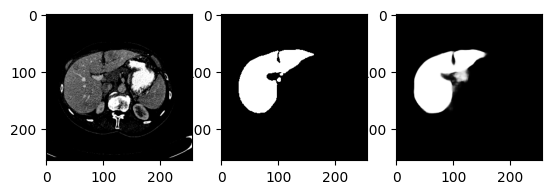

30659.0
1/1 [==============================] - 0s 19ms/step


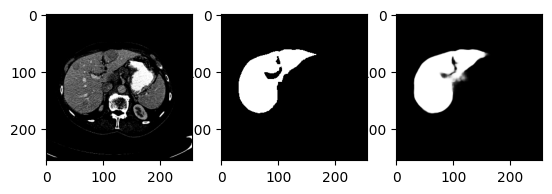

32350.0
1/1 [==============================] - 0s 20ms/step


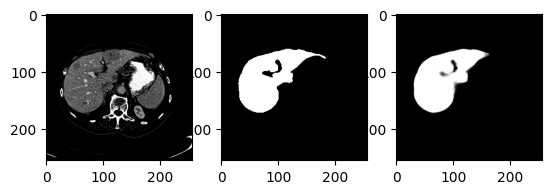

32528.0
1/1 [==============================] - 0s 20ms/step


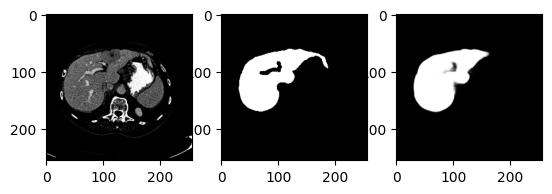

33310.0
1/1 [==============================] - 0s 21ms/step


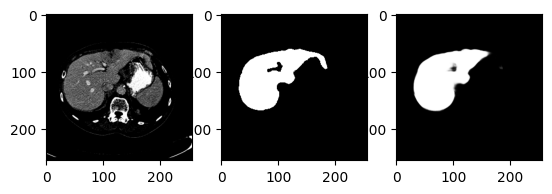

34229.0
1/1 [==============================] - 0s 20ms/step


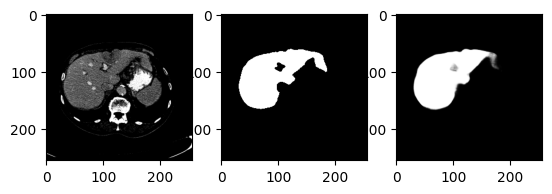

34465.0
1/1 [==============================] - 0s 21ms/step


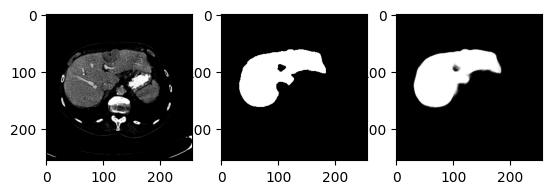

34191.0
1/1 [==============================] - 0s 26ms/step


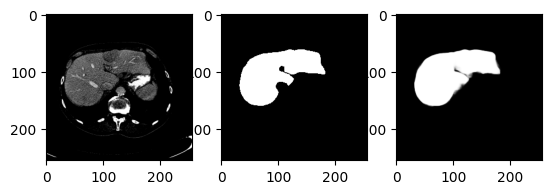

32090.0
1/1 [==============================] - 0s 20ms/step


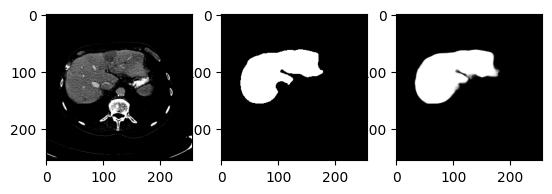

30252.0
1/1 [==============================] - 0s 19ms/step


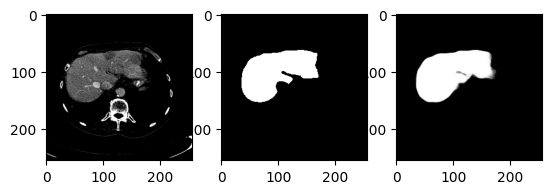

26948.0
1/1 [==============================] - 0s 22ms/step


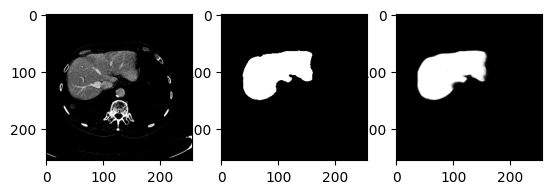

23016.0
1/1 [==============================] - 0s 21ms/step


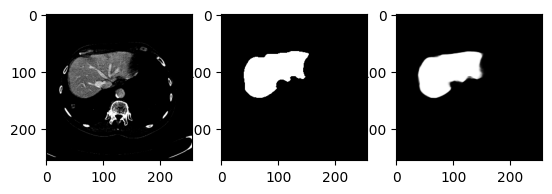

19080.0
1/1 [==============================] - 0s 20ms/step


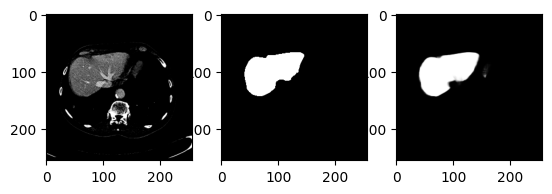

13971.0
1/1 [==============================] - 0s 19ms/step


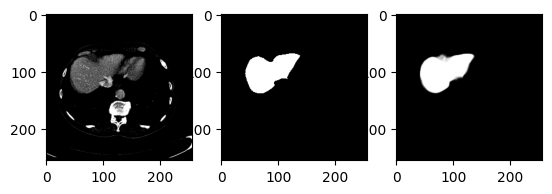

8614.0
1/1 [==============================] - 0s 19ms/step


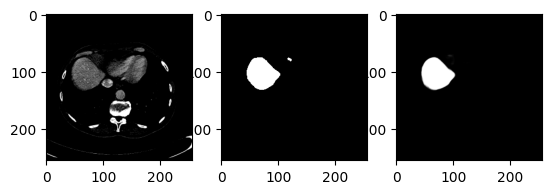

6771.0
1/1 [==============================] - 0s 19ms/step


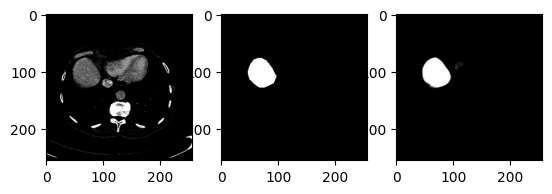

5304.0
1/1 [==============================] - 0s 20ms/step


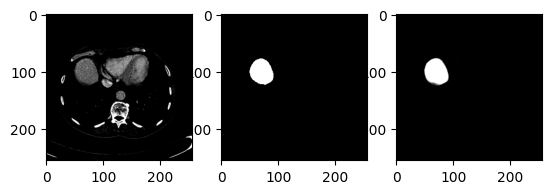

3920.0
1/1 [==============================] - 0s 21ms/step


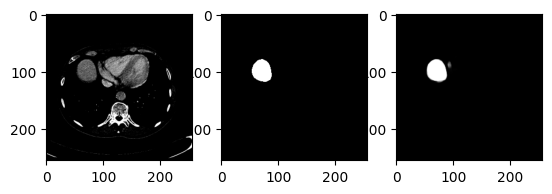

2685.0
1/1 [==============================] - 0s 19ms/step


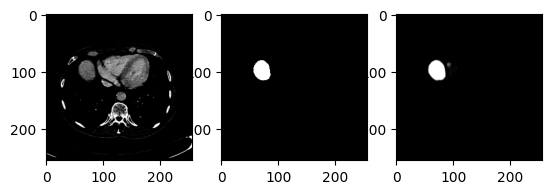

1407.0
1/1 [==============================] - 0s 19ms/step


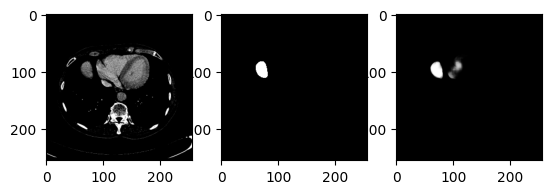

582.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
104.0
677.0
1533.0
1/1 [==============================] - 0s 17ms/step


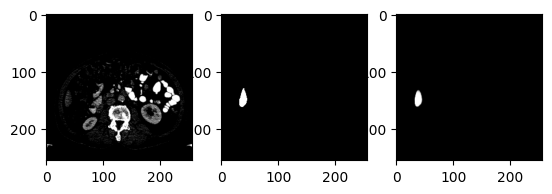

2560.0
1/1 [==============================] - 0s 21ms/step


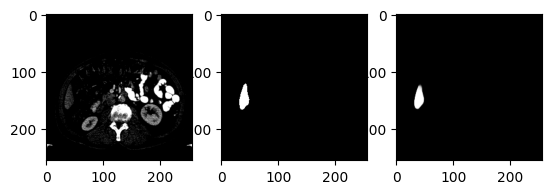

3971.0
1/1 [==============================] - 0s 19ms/step


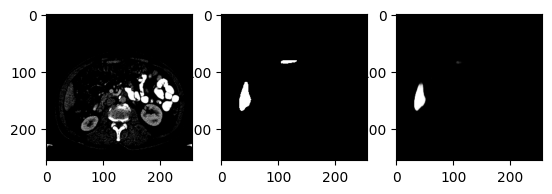

5654.0
1/1 [==============================] - 0s 20ms/step


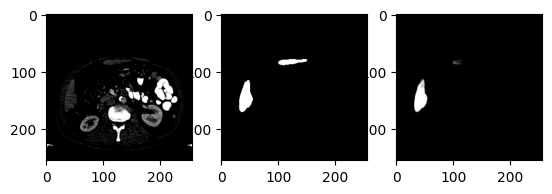

7709.0
1/1 [==============================] - 0s 20ms/step


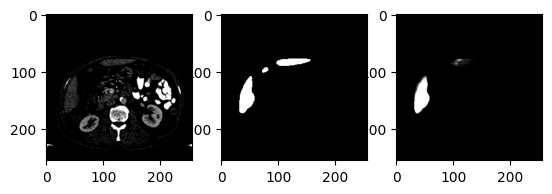

9388.0
1/1 [==============================] - 0s 19ms/step


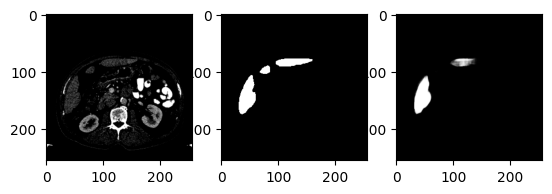

11500.0
1/1 [==============================] - 0s 21ms/step


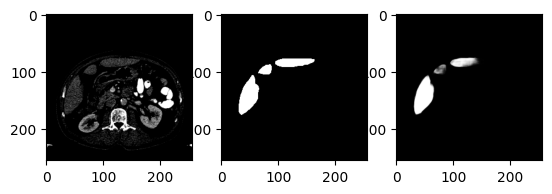

13862.0
1/1 [==============================] - 0s 20ms/step


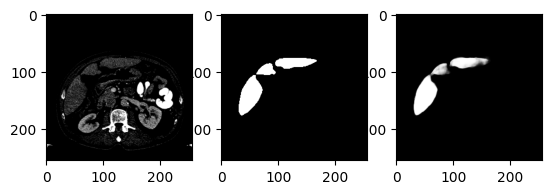

16384.0
1/1 [==============================] - 0s 20ms/step


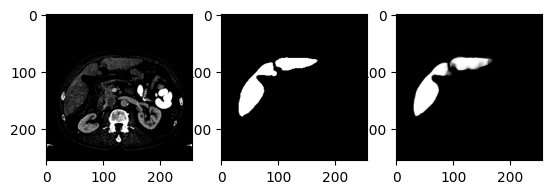

19745.0
1/1 [==============================] - 0s 20ms/step


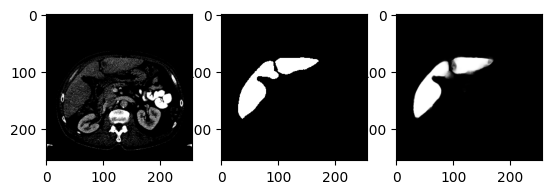

23225.0
1/1 [==============================] - 0s 20ms/step


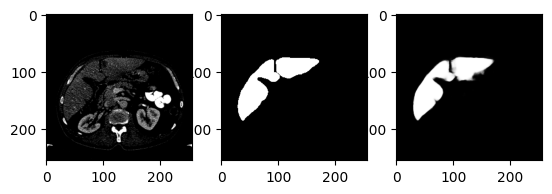

26457.0
1/1 [==============================] - 0s 21ms/step


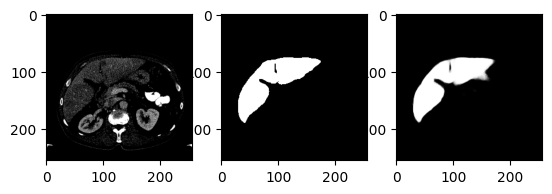

29116.0
1/1 [==============================] - 0s 21ms/step


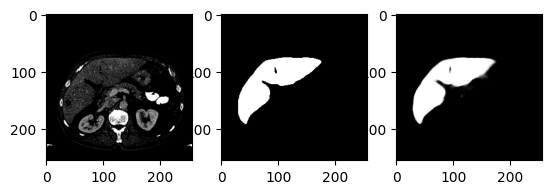

31935.0
1/1 [==============================] - 0s 21ms/step


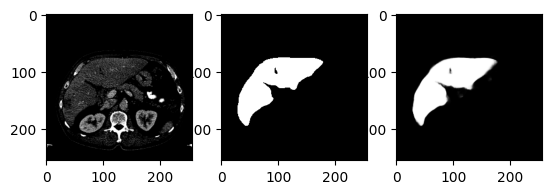

34151.0
1/1 [==============================] - 0s 20ms/step


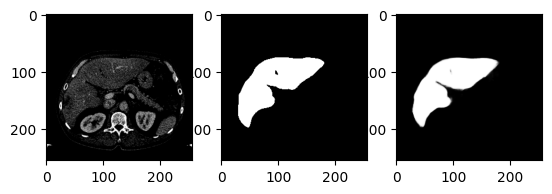

36319.0
1/1 [==============================] - 0s 19ms/step


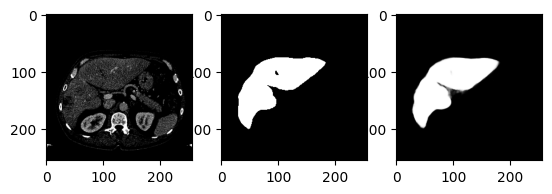

38830.0
1/1 [==============================] - 0s 21ms/step


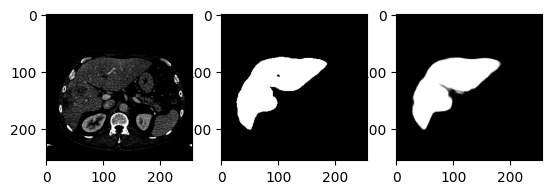

40892.0
1/1 [==============================] - 0s 31ms/step


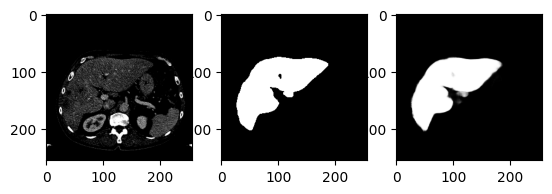

42573.0
1/1 [==============================] - 0s 21ms/step


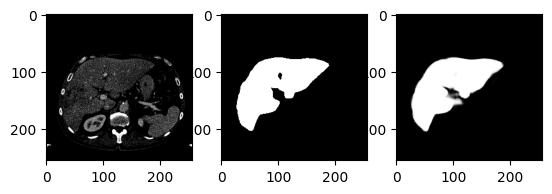

43852.0
1/1 [==============================] - 0s 31ms/step


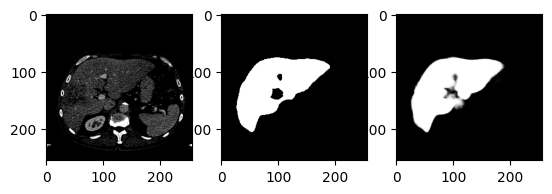

44845.0
1/1 [==============================] - 0s 19ms/step


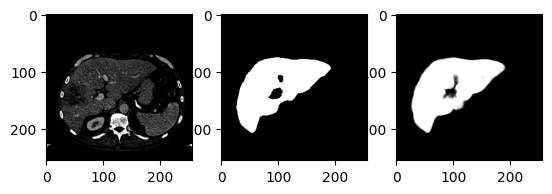

45490.0
1/1 [==============================] - 0s 41ms/step


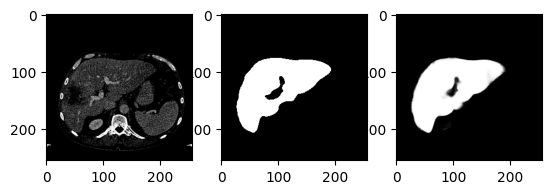

46929.0
1/1 [==============================] - 0s 20ms/step


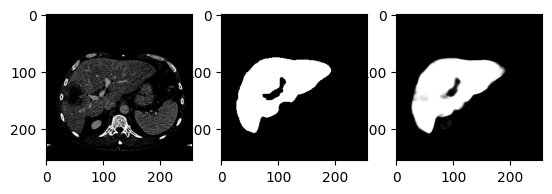

47617.0
1/1 [==============================] - 0s 24ms/step


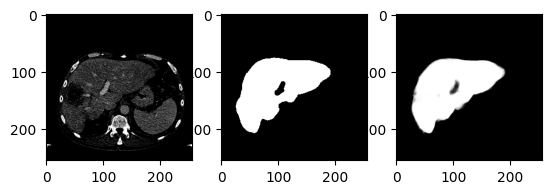

48189.0
1/1 [==============================] - 0s 20ms/step


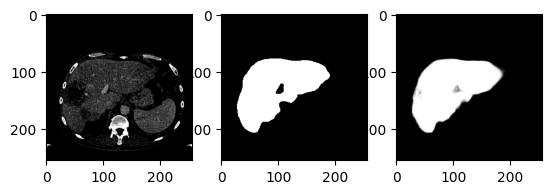

47925.0
1/1 [==============================] - 0s 20ms/step


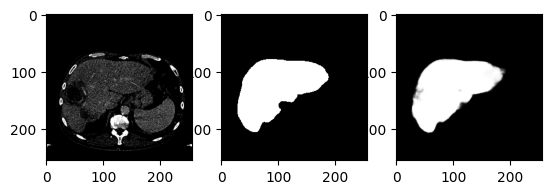

47246.0
1/1 [==============================] - 0s 19ms/step


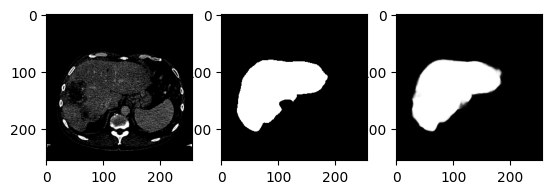

45736.0
1/1 [==============================] - 0s 22ms/step


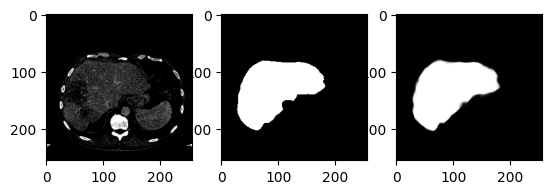

42611.0
1/1 [==============================] - 0s 21ms/step


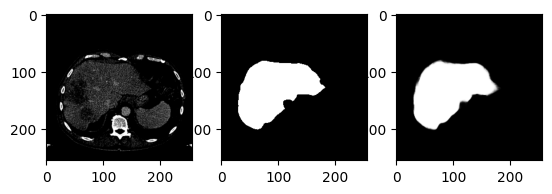

38951.0
1/1 [==============================] - 0s 21ms/step


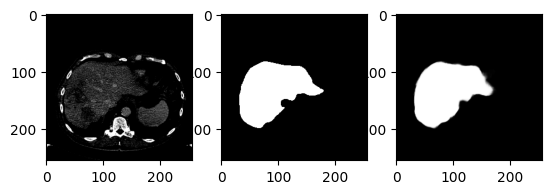

33727.0
1/1 [==============================] - 0s 20ms/step


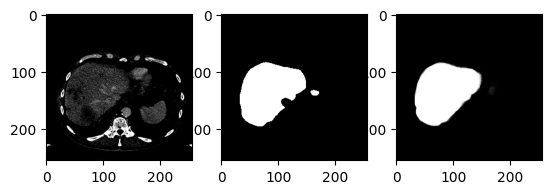

28926.0
1/1 [==============================] - 0s 19ms/step


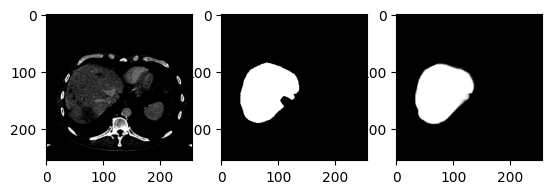

25159.0
1/1 [==============================] - 0s 19ms/step


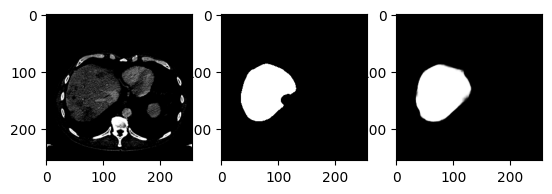

21563.0
1/1 [==============================] - 0s 19ms/step


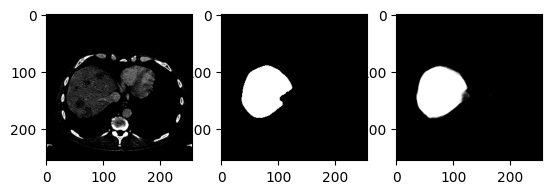

18419.0
1/1 [==============================] - 0s 21ms/step


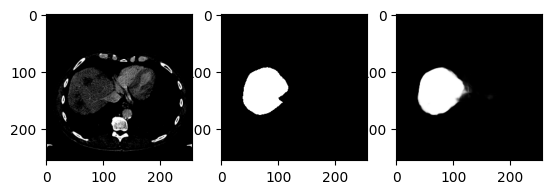

15566.0
1/1 [==============================] - 0s 20ms/step


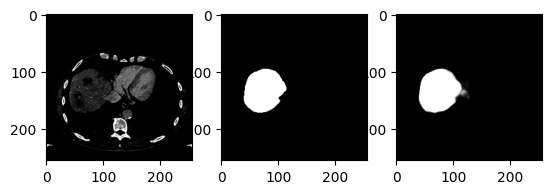

11912.0
1/1 [==============================] - 0s 19ms/step


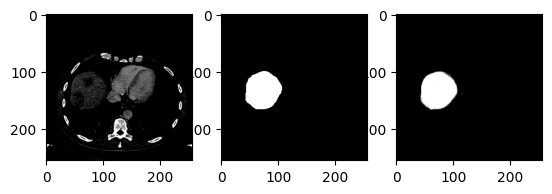

8873.0
1/1 [==============================] - 0s 21ms/step


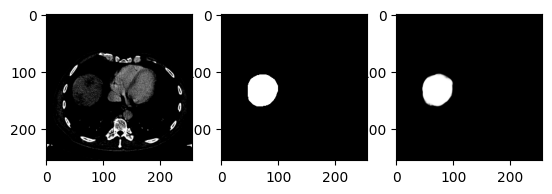

6147.0
1/1 [==============================] - 0s 19ms/step


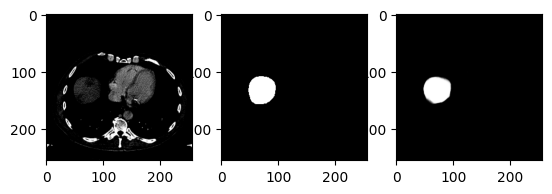

3434.0
1/1 [==============================] - 0s 20ms/step


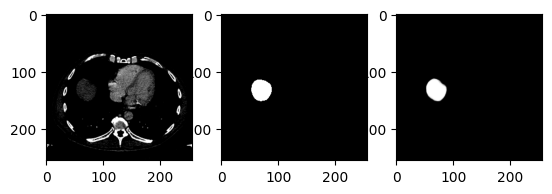

1002.0
1/1 [==============================] - 0s 21ms/step


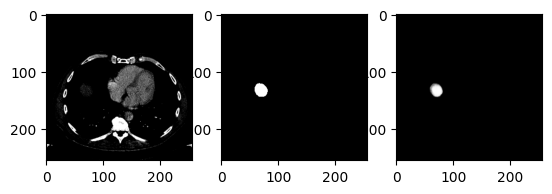

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
319.0
1215.0
1/1 [==============================] - 0s 20ms/step


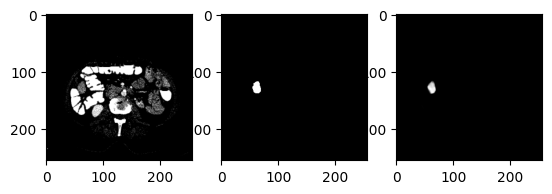

2263.0
1/1 [==============================] - 0s 21ms/step


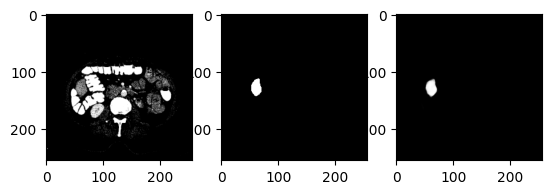

3532.0
1/1 [==============================] - 0s 20ms/step


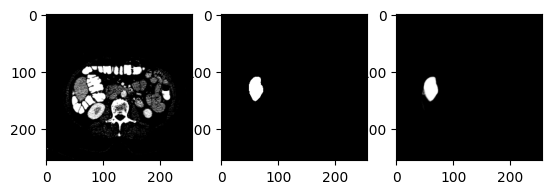

5314.0
1/1 [==============================] - 0s 21ms/step


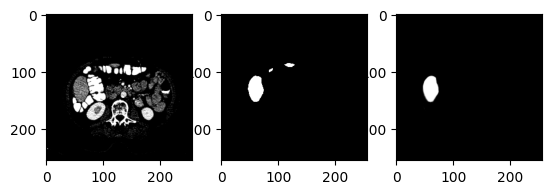

7254.0
1/1 [==============================] - 0s 20ms/step


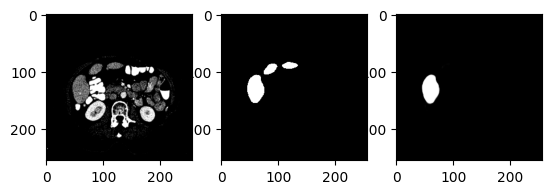

9182.0
1/1 [==============================] - 0s 23ms/step


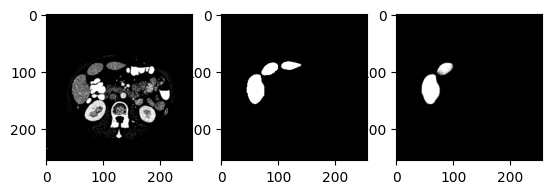

11071.0
1/1 [==============================] - 0s 21ms/step


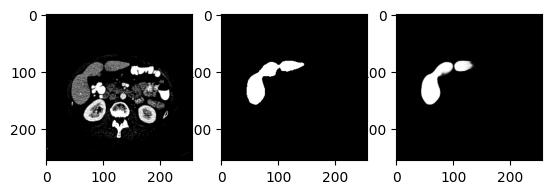

12949.0
1/1 [==============================] - 0s 20ms/step


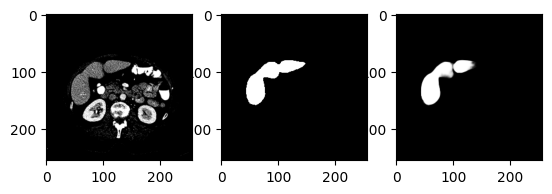

14521.0
1/1 [==============================] - 0s 20ms/step


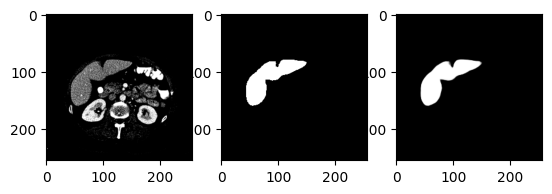

16032.0
1/1 [==============================] - 0s 27ms/step


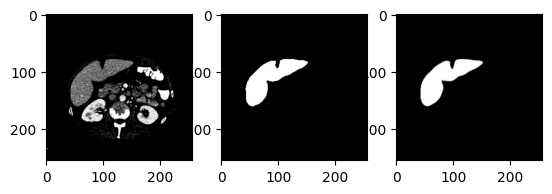

17414.0
1/1 [==============================] - 0s 21ms/step


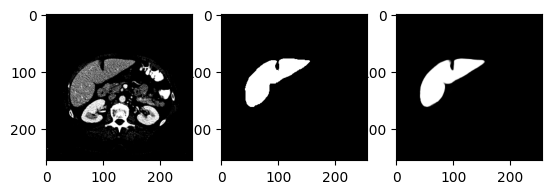

18664.0
1/1 [==============================] - 0s 18ms/step


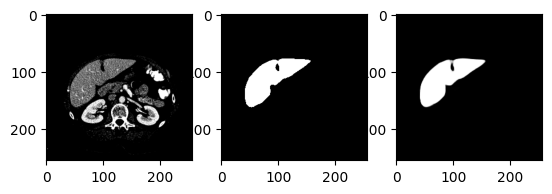

19819.0
1/1 [==============================] - 0s 20ms/step


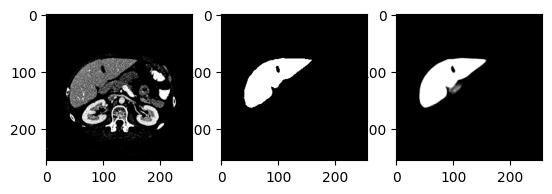

20914.0
1/1 [==============================] - 0s 25ms/step


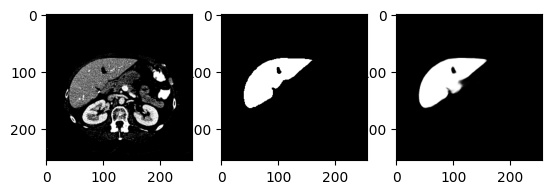

22338.0
1/1 [==============================] - 0s 18ms/step


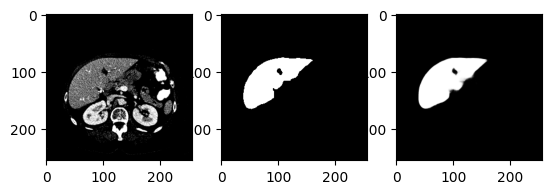

23864.0
1/1 [==============================] - 0s 22ms/step


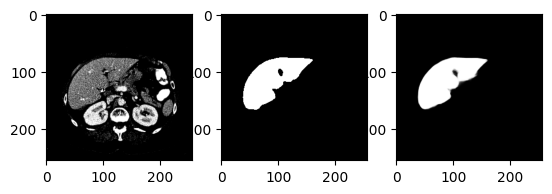

24787.0
1/1 [==============================] - 0s 21ms/step


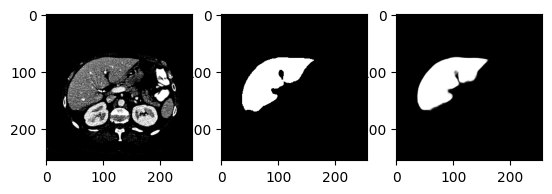

25572.0
1/1 [==============================] - 0s 20ms/step


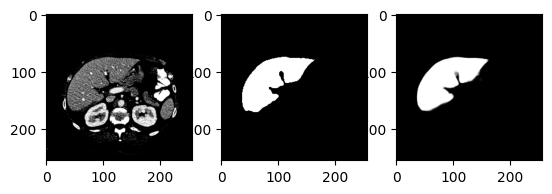

26270.0
1/1 [==============================] - 0s 20ms/step


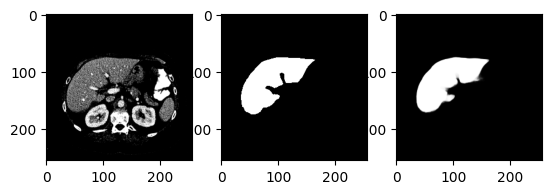

27059.0
1/1 [==============================] - 0s 21ms/step


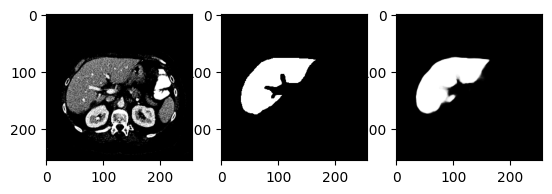

29233.0
1/1 [==============================] - 0s 19ms/step


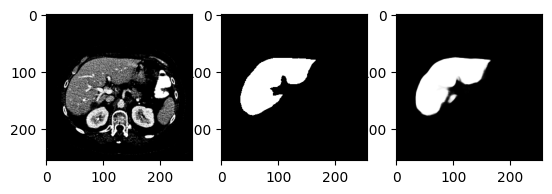

31542.0
1/1 [==============================] - 0s 21ms/step


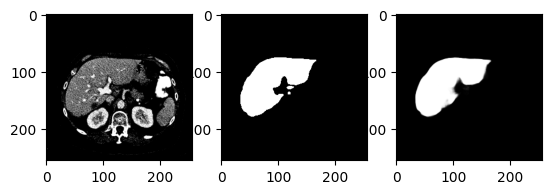

34366.0
1/1 [==============================] - 0s 22ms/step


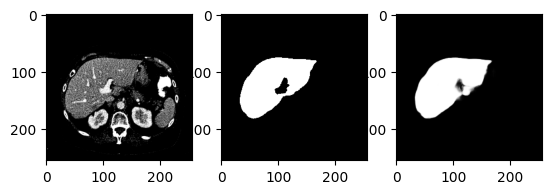

36911.0
1/1 [==============================] - 0s 19ms/step


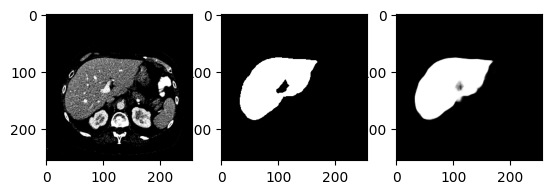

38925.0
1/1 [==============================] - 0s 20ms/step


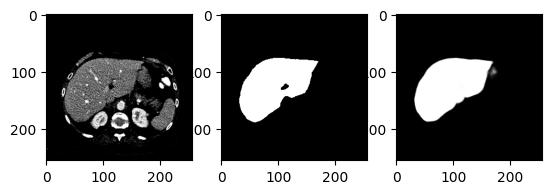

39967.0
1/1 [==============================] - 0s 20ms/step


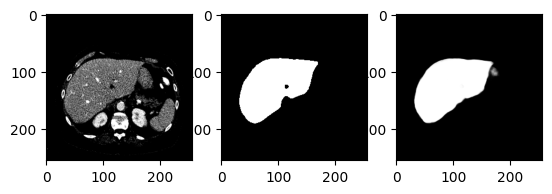

41146.0
1/1 [==============================] - 0s 21ms/step


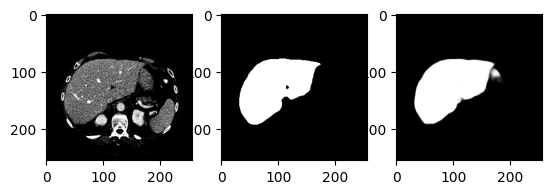

41871.0
1/1 [==============================] - 0s 19ms/step


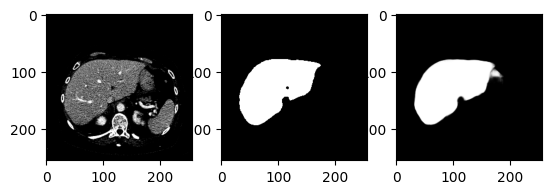

42236.0
1/1 [==============================] - 0s 18ms/step


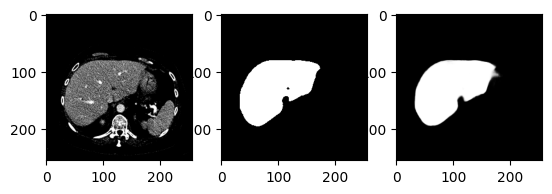

42628.0
1/1 [==============================] - 0s 21ms/step


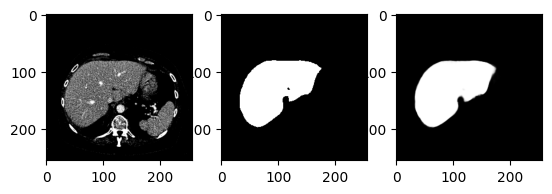

42392.0
1/1 [==============================] - 0s 21ms/step


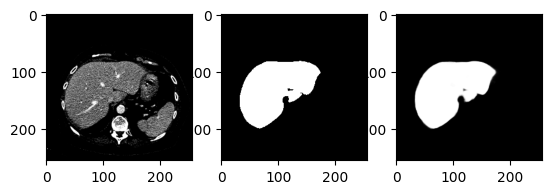

42112.0
1/1 [==============================] - 0s 19ms/step


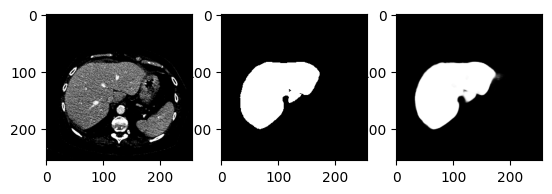

41367.0
1/1 [==============================] - 0s 24ms/step


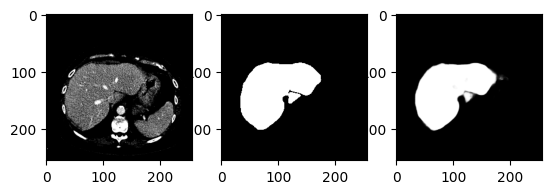

39659.0
1/1 [==============================] - 0s 22ms/step


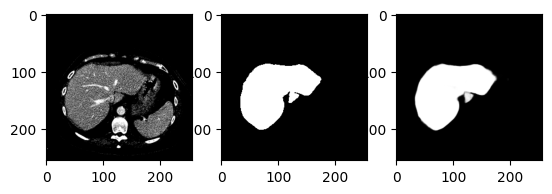

37523.0
1/1 [==============================] - 0s 19ms/step


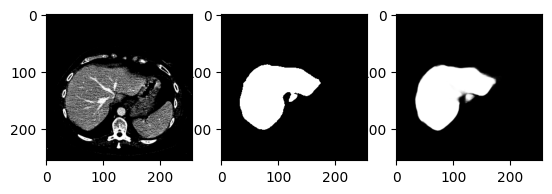

34402.0
1/1 [==============================] - 0s 20ms/step


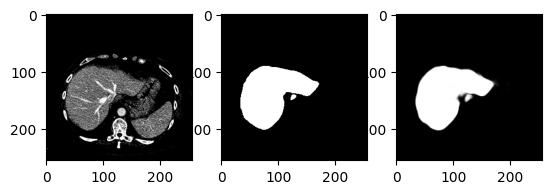

30393.0
1/1 [==============================] - 0s 21ms/step


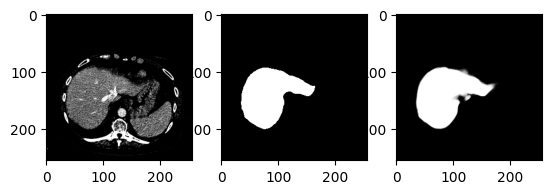

27669.0
1/1 [==============================] - 0s 21ms/step


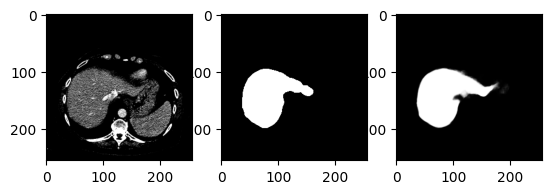

22848.0
1/1 [==============================] - 0s 19ms/step


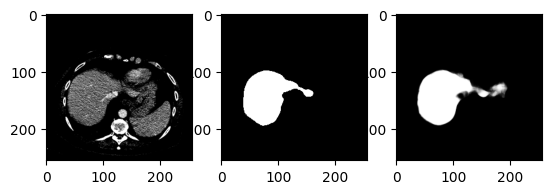

19202.0
1/1 [==============================] - 0s 20ms/step


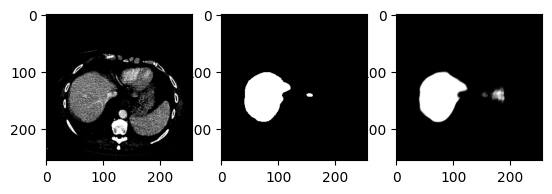

15638.0
1/1 [==============================] - 0s 21ms/step


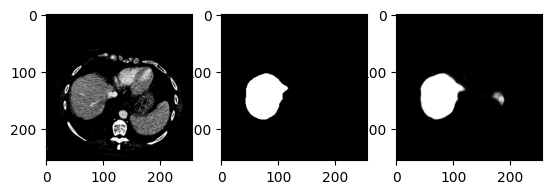

11620.0
1/1 [==============================] - 0s 21ms/step


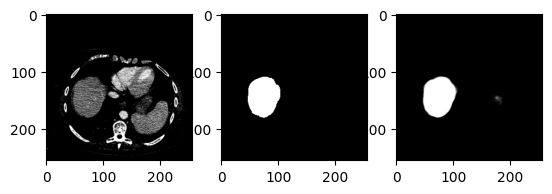

6855.0
1/1 [==============================] - 0s 20ms/step


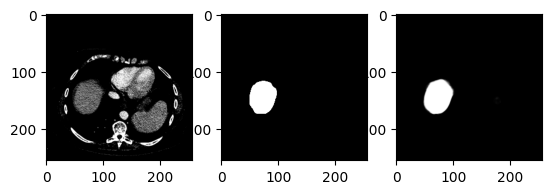

2194.0
1/1 [==============================] - 0s 21ms/step


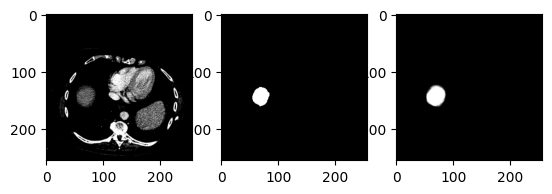

139.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
182.0
706.0
1440.0
1/1 [==============================] - 0s 17ms/step


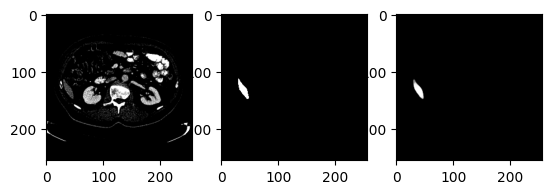

2274.0
1/1 [==============================] - 0s 21ms/step


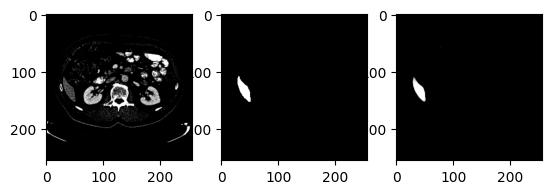

3189.0
1/1 [==============================] - 0s 20ms/step


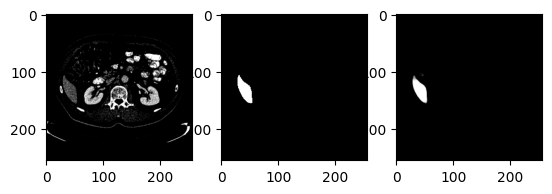

4104.0
1/1 [==============================] - 0s 21ms/step


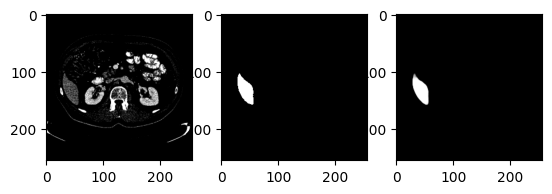

5092.0
1/1 [==============================] - 0s 19ms/step


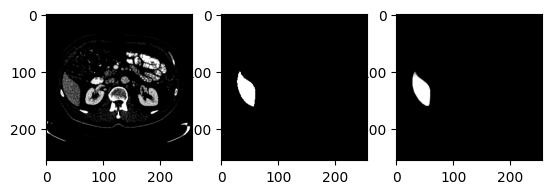

6203.0
1/1 [==============================] - 0s 21ms/step


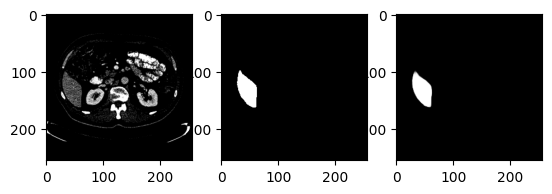

7510.0
1/1 [==============================] - 0s 19ms/step


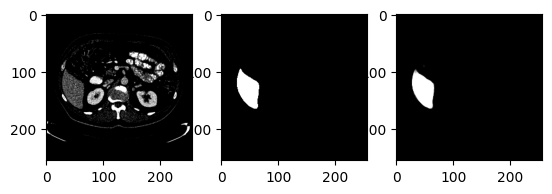

8793.0
1/1 [==============================] - 0s 19ms/step


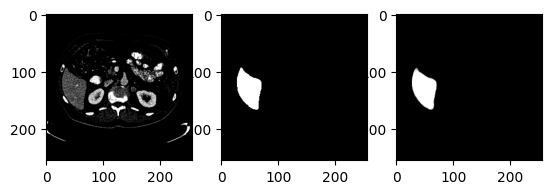

10407.0
1/1 [==============================] - 0s 28ms/step


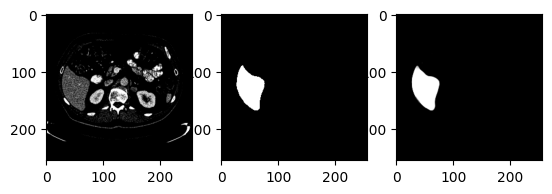

12405.0
1/1 [==============================] - 0s 37ms/step


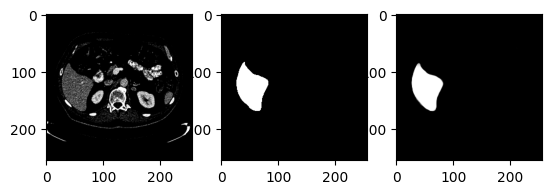

14470.0
1/1 [==============================] - 0s 19ms/step


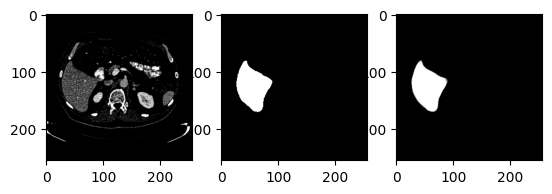

16004.0
1/1 [==============================] - 0s 21ms/step


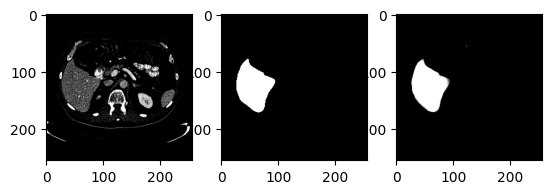

17050.0
1/1 [==============================] - 0s 21ms/step


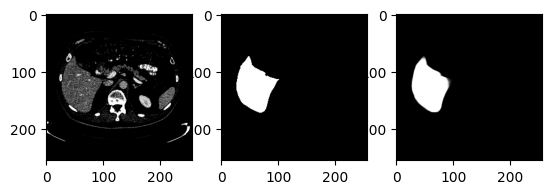

17761.0
1/1 [==============================] - 0s 18ms/step


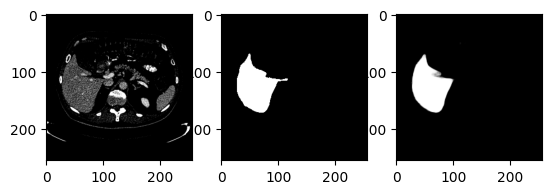

18483.0
1/1 [==============================] - 0s 19ms/step


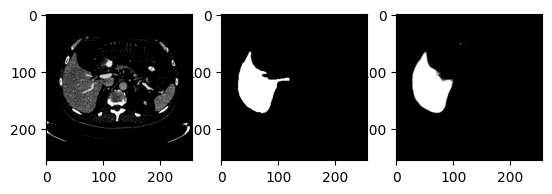

21085.0
1/1 [==============================] - 0s 20ms/step


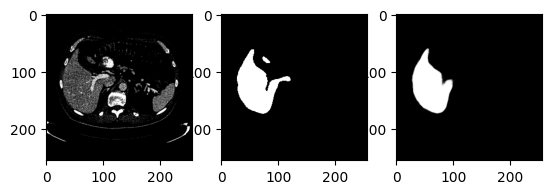

24191.0
1/1 [==============================] - 0s 20ms/step


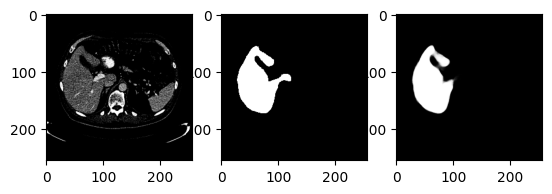

26941.0
1/1 [==============================] - 0s 21ms/step


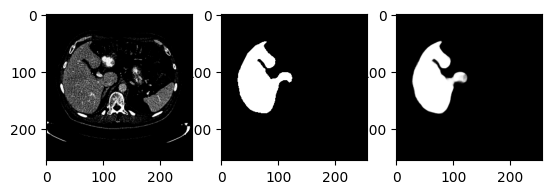

28825.0
1/1 [==============================] - 0s 19ms/step


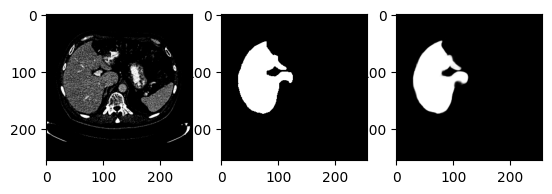

30074.0
1/1 [==============================] - 0s 21ms/step


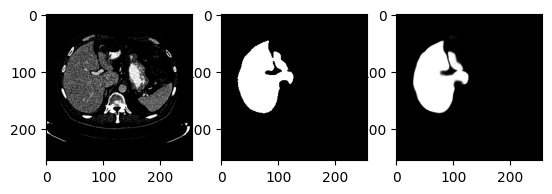

31447.0
1/1 [==============================] - 0s 19ms/step


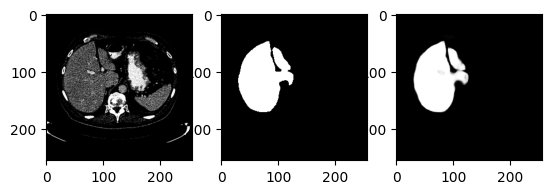

23929.0
1/1 [==============================] - 0s 20ms/step


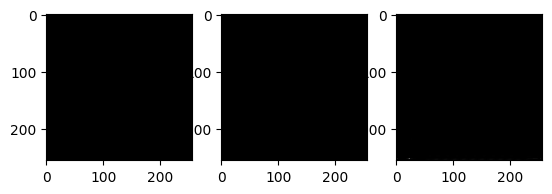

31767.0
1/1 [==============================] - 0s 19ms/step


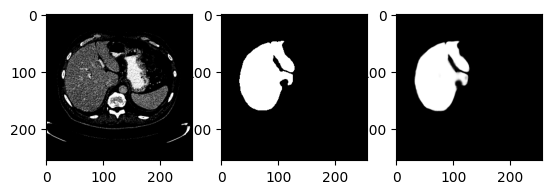

31864.0
1/1 [==============================] - 0s 19ms/step


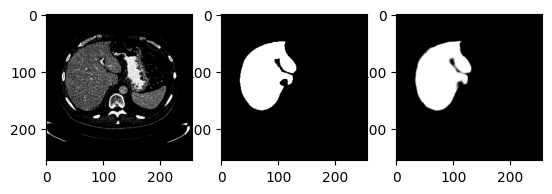

32038.0
1/1 [==============================] - 0s 20ms/step


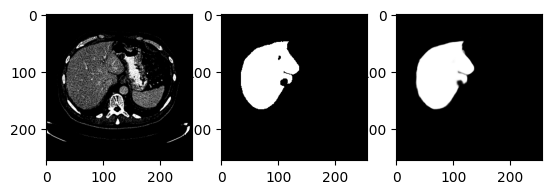

31482.0
1/1 [==============================] - 0s 22ms/step


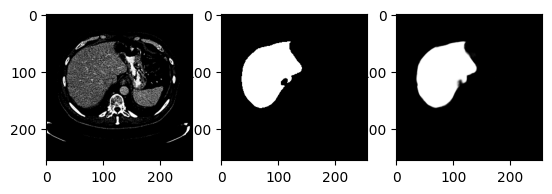

30569.0
1/1 [==============================] - 0s 18ms/step


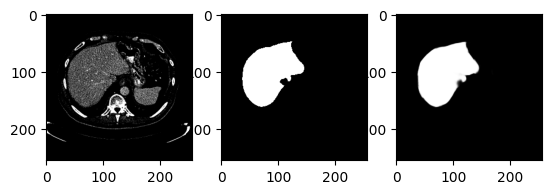

29625.0
1/1 [==============================] - 0s 20ms/step


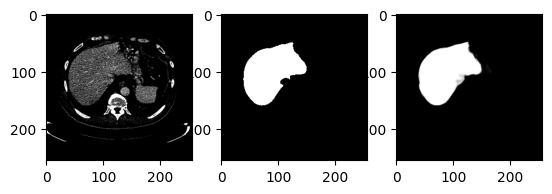

28052.0
1/1 [==============================] - 0s 21ms/step


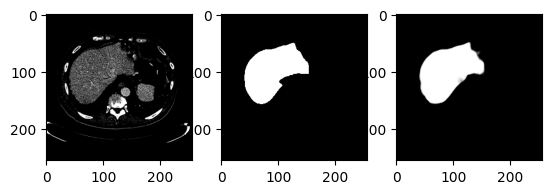

24593.0
1/1 [==============================] - 0s 20ms/step


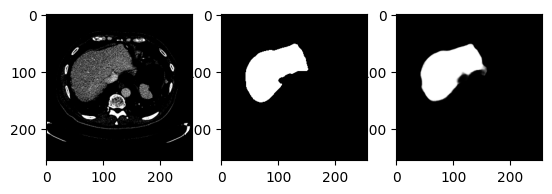

19871.0
1/1 [==============================] - 0s 21ms/step


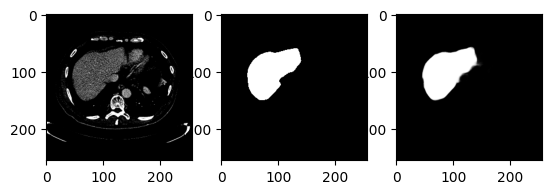

15366.0
1/1 [==============================] - 0s 19ms/step


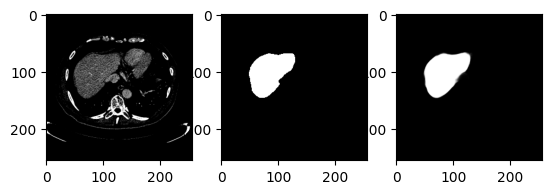

10322.0
1/1 [==============================] - 0s 22ms/step


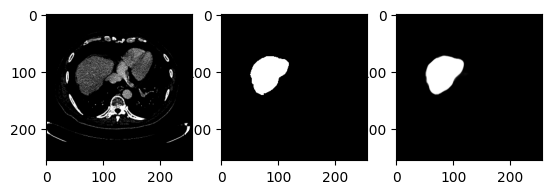

6239.0
1/1 [==============================] - 0s 19ms/step


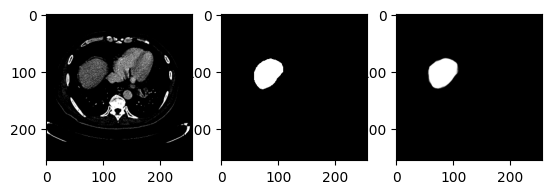

2516.0
1/1 [==============================] - 0s 20ms/step


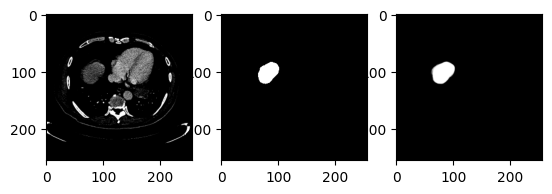

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [28]:
for sample in valid_dataset.take(1000):
    print(np.sum(sample[1]))
    if np.sum(sample[1]) > 1000:
        presd = model.predict(sample[0])
        plt.subplot(1,3,1)
        plt.imshow(sample[0][0,:,:,0],cmap='gray')
        plt.subplot(1,3,2)
        plt.imshow(sample[1][0,:,:,0],cmap='gray')
        plt.subplot(1,3,3)
        plt.imshow(presd[0,:,:,0],cmap='gray')
        plt.show()
    